In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
df = pd.read_csv('UNSW_NB15_training-set.csv')

In [3]:
from sklearn.preprocessing import LabelEncoder

# Label encoding for 'proto', 'service', 'state'
label_encoder = LabelEncoder()
for col in ['proto', 'service', 'state']:
    df[col] = label_encoder.fit_transform(df[col])

# One-hot encoding for 'attack_cat'
attack_cat_dummies = pd.get_dummies(df['attack_cat'], prefix='attack_cat')
df = pd.concat([df, attack_cat_dummies], axis=1)

# Optional: Ensure integer type for dummy variables
dummy_columns = attack_cat_dummies.columns
df[dummy_columns] = df[dummy_columns].astype(int)

# Drop the original 'attack_cat' column if no longer needed
df.drop(columns=['attack_cat'], inplace=True)

# Display the DataFrame
df


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,attack_cat_Analysis,attack_cat_Backdoor,attack_cat_DoS,attack_cat_Exploits,attack_cat_Fuzzers,attack_cat_Generic,attack_cat_Normal,attack_cat_Reconnaissance,attack_cat_Shellcode,attack_cat_Worms
0,1,0.121478,113,0,2,6,4,258,172,74.087490,...,0,0,0,0,0,0,1,0,0,0
1,2,0.649902,113,0,2,14,38,734,42014,78.473372,...,0,0,0,0,0,0,1,0,0,0
2,3,1.623129,113,0,2,8,16,364,13186,14.170161,...,0,0,0,0,0,0,1,0,0,0
3,4,1.681642,113,3,2,12,12,628,770,13.677108,...,0,0,0,0,0,0,1,0,0,0
4,5,0.449454,113,0,2,10,6,534,268,33.373826,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,119,2,3,2,0,114,0,111111.107200,...,0,0,0,0,0,1,0,0,0,0
175337,175338,0.505762,113,0,2,10,8,620,354,33.612649,...,0,0,0,0,0,0,0,0,1,0
175338,175339,0.000009,119,2,3,2,0,114,0,111111.107200,...,0,0,0,0,0,1,0,0,0,0
175339,175340,0.000009,119,2,3,2,0,114,0,111111.107200,...,0,0,0,0,0,1,0,0,0,0


In [4]:
from collections import Counter

filtered_df = df[df['label'] == 1]

xs = filtered_df.drop(columns = ['id','label','attack_cat_Normal', 'attack_cat_Analysis','attack_cat_Backdoor', 'attack_cat_DoS', 'attack_cat_Exploits', 
      'attack_cat_Fuzzers', 'attack_cat_Generic',
      'attack_cat_Reconnaissance', 'attack_cat_Shellcode', 'attack_cat_Worms'])

ys = filtered_df[['attack_cat_Analysis','attack_cat_Backdoor', 'attack_cat_DoS', 'attack_cat_Exploits', 
      'attack_cat_Fuzzers', 'attack_cat_Generic',  
      'attack_cat_Reconnaissance', 'attack_cat_Shellcode', 'attack_cat_Worms']]

X_train = xs
y_train = ys

print(xs.shape)
print(ys.shape)

# Ensure ys is converted to labels
class_labels = ys.idxmax(axis=1)  # Converts one-hot encoded columns to class labels
counter = Counter(class_labels)

# Display the distribution
total = len(class_labels)
for cls, count in counter.items():
    percentage = count / total * 100
    print(f'Class = {cls}, n = {count} ({percentage:.3f}%)')

(119341, 42)
(119341, 9)
Class = attack_cat_Backdoor, n = 1746 (1.463%)
Class = attack_cat_Analysis, n = 2000 (1.676%)
Class = attack_cat_Fuzzers, n = 18184 (15.237%)
Class = attack_cat_Shellcode, n = 1133 (0.949%)
Class = attack_cat_Reconnaissance, n = 10491 (8.791%)
Class = attack_cat_Exploits, n = 33393 (27.981%)
Class = attack_cat_DoS, n = 12264 (10.276%)
Class = attack_cat_Worms, n = 130 (0.109%)
Class = attack_cat_Generic, n = 40000 (33.517%)


Class = attack_cat_Backdoor, n = 1746 (1.463%)
Class = attack_cat_Analysis, n = 2000 (1.676%)
Class = attack_cat_Fuzzers, n = 18184 (15.237%)
Class = attack_cat_Shellcode, n = 1133 (0.949%)
Class = attack_cat_Reconnaissance, n = 10491 (8.791%)
Class = attack_cat_Exploits, n = 33393 (27.981%)
Class = attack_cat_DoS, n = 12264 (10.276%)
Class = attack_cat_Worms, n = 130 (0.109%)
Class = attack_cat_Generic, n = 40000 (33.517%)


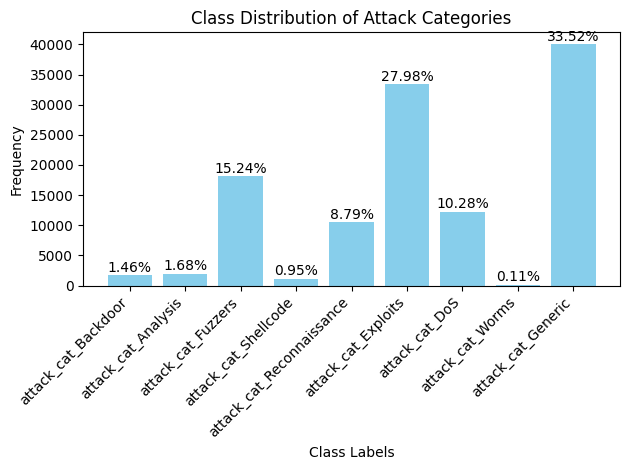

X after sampling:  (360000, 42)
y after sampling:  (360000, 9)


In [5]:
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE

# Assuming filtered_df and necessary columns are already set up
filtered_df = df[df['label'] == 1]

xs = filtered_df.drop(columns = ['id','label','attack_cat_Normal', 'attack_cat_Analysis','attack_cat_Backdoor', 'attack_cat_DoS', 'attack_cat_Exploits', 
      'attack_cat_Fuzzers', 'attack_cat_Generic',
      'attack_cat_Reconnaissance', 'attack_cat_Shellcode', 'attack_cat_Worms'])

ys = filtered_df[['attack_cat_Analysis','attack_cat_Backdoor', 'attack_cat_DoS', 'attack_cat_Exploits', 
      'attack_cat_Fuzzers', 'attack_cat_Generic',  
      'attack_cat_Reconnaissance', 'attack_cat_Shellcode', 'attack_cat_Worms']]

X_train = xs
y_train = ys

# Ensure ys is converted to labels
class_labels = ys.idxmax(axis=1)  # Converts one-hot encoded columns to class labels
counter = Counter(class_labels)

# Display the distribution
total = len(class_labels)
for cls, count in counter.items():
    percentage = count / total * 100
    print(f'Class = {cls}, n = {count} ({percentage:.3f}%)')

# Now plot the bar graph
labels = list(counter.keys())
counts = list(counter.values())

# Create the bar plot
plt.bar(labels, counts, color='skyblue')

# Add percentage labels on top of each bar
for i, count in enumerate(counts):
    percentage = count / total * 100
    plt.text(i, count + 50, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=10)

# Labeling the axes and the title
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution of Attack Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Ensures everything fits without overlap
plt.show()

# Resampling with SMOTE
X_train = X_train.values
y_train = y_train.values

smote = SMOTE()

X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)

print("X after sampling: ", X_train_sampled.shape)
print("y after sampling: ", y_train_sampled.shape)


X after sampling:  (360000, 42)
y after sampling:  (360000, 9)
Class = 1, n = 40000 (11.111%)
Class = 0, n = 40000 (11.111%)
Class = 4, n = 40000 (11.111%)
Class = 7, n = 40000 (11.111%)
Class = 6, n = 40000 (11.111%)
Class = 3, n = 40000 (11.111%)
Class = 2, n = 40000 (11.111%)
Class = 8, n = 40000 (11.111%)
Class = 5, n = 40000 (11.111%)


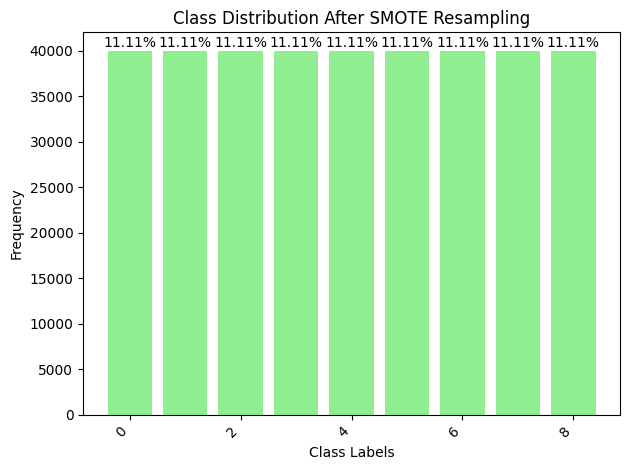

In [6]:
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE

# Assuming X_train and y_train are already defined and contain the dataset
X_train = X_train
y_train = y_train

# Apply SMOTE to balance the dataset
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)

# Display the shape of the resampled data
print("X after sampling: ", X_train_sampled.shape)
print("y after sampling: ", y_train_sampled.shape)

# Convert the resampled y_train_sampled to class labels (one-hot to class labels)
class_labels_sampled = y_train_sampled.argmax(axis=1)  # Assuming y_train_sampled is one-hot encoded

# Count the distribution of class labels after resampling
counter_sampled = Counter(class_labels_sampled)

# Display the distribution of classes after resampling
total_sampled = len(class_labels_sampled)
for cls, count in counter_sampled.items():
    percentage = count / total_sampled * 100
    print(f'Class = {cls}, n = {count} ({percentage:.3f}%)')

# Plot the class distribution after SMOTE
labels_sampled = list(counter_sampled.keys())
counts_sampled = list(counter_sampled.values())

plt.bar(labels_sampled, counts_sampled, color='lightgreen')
# Add percentage labels on top of each bar
for i, count in enumerate(counts_sampled):
    percentage = count / total_sampled * 100
    plt.text(i, count + 50, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=10)
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution After SMOTE Resampling')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Ensures everything fits without overlap
plt.show()
